In [1]:
import numpy as np
import nengo
from nengo import Lowpass
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import scipy.io
from model import DotPerception, build_network
palette = sns.color_palette("colorblind")
sns.set_palette(palette)
sns.set(context='paper', style='ticks', rc={'font.size':12, 'mathtext.fontset': 'cm'})

In [2]:
def make_hanks_behavior_dataframe():
    # convert original matlab files into a single pandas dataframe
    dfs = []
    columns = ('type', 'id', 'emphasis', 'trial', 'coherence', 'accuracy', 'RT')

    for name in ['E', 'D']:
        if name=='E': emp = scipy.io.loadmat("data/behavData_eli.mat", simplify_cells=True)
        if name=='D': emp = scipy.io.loadmat("data/behavData_dam.mat", simplify_cells=True)
        for e, emphasis in enumerate(['speed', 'accuracy']):
            cond = emp['task'][e]
            coherences = 100*cond['data']['coh']
            accuracies = 100*cond['data']['cor']
            rts = 0.001*cond['data']['rt']
            trials = coherences.shape[0]
            for t in range(trials):
                dfs.append(pd.DataFrame([['monkey', name, emphasis, t, coherences[t], accuracies[t], rts[t]]], columns=columns))

    hanks_behavior = pd.concat(dfs, ignore_index=True)
    hanks_behavior.to_pickle("data/hanks2014_behavior.pkl")

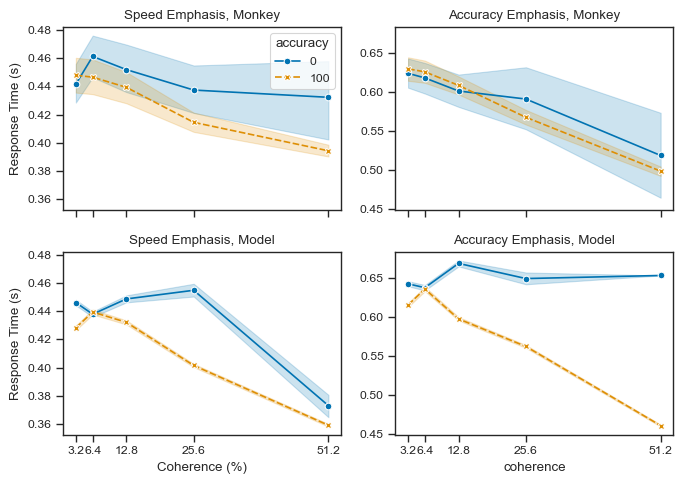

In [29]:
name = "dec27sigma06"
pid="E"
estimator=np.mean
bins=np.arange(0.0, 1.5, 0.1)

data = pd.read_pickle(f"data/{name}.pkl")
hanks = pd.read_pickle("data/hanks2014_behavior.pkl").query("id==@pid & coherence>0")
cohs = hanks['coherence'].unique()

fig, axes = plt.subplots(nrows=2, ncols=2, sharex=True, sharey='col', figsize=((7, 5)))
sns.lineplot(data=hanks.query("emphasis=='speed'"), x='coherence', y='RT',
             palette=palette[:2], markers=True, ax=axes[0][0], hue='accuracy',
             style='accuracy', estimator=estimator)
sns.lineplot(data=hanks.query("emphasis=='accuracy'"), x='coherence', y='RT',
             palette=palette[:2], markers=True, ax=axes[0][1], hue='accuracy',
             style='accuracy', estimator=estimator)
sns.lineplot(data=data.query("emphasis=='speed'"), x='coherence', y='RT',
             palette=palette[:2], markers=True, ax=axes[1][0], hue='accuracy',
             style='accuracy', estimator=estimator)
sns.lineplot(data=data.query("emphasis=='accuracy'"), x='coherence', y='RT',
             palette=palette[:2], markers=True, ax=axes[1][1], hue='accuracy',
             style='accuracy', estimator=estimator)
axes[0][0].set(xticks=cohs, xticklabels=cohs, xlabel="Coherence (%)", ylabel="Response Time (s)")
axes[1][0].set(xticks=cohs, xticklabels=cohs, xlabel="Coherence (%)", ylabel="Response Time (s)")
axes[0][1].set(ylabel=None)
axes[1][1].set(ylabel=None)
axes[0][0].set(title="Speed Emphasis, Monkey")
axes[0][1].set(title="Accuracy Emphasis, Monkey")
axes[1][0].set(title="Speed Emphasis, Model")
axes[1][1].set(title="Accuracy Emphasis, Model")
# axes[1].set(xscale='log', xlabel="Coherence (%)", ylabel="Response Time (s)")
# axes[0].legend(ncols=2, loc='upper right')
axes[0][1].get_legend().remove()
axes[1][0].get_legend().remove()
axes[1][1].get_legend().remove()
plt.tight_layout()

In [3]:
# make_hanks_behavior_dataframe()

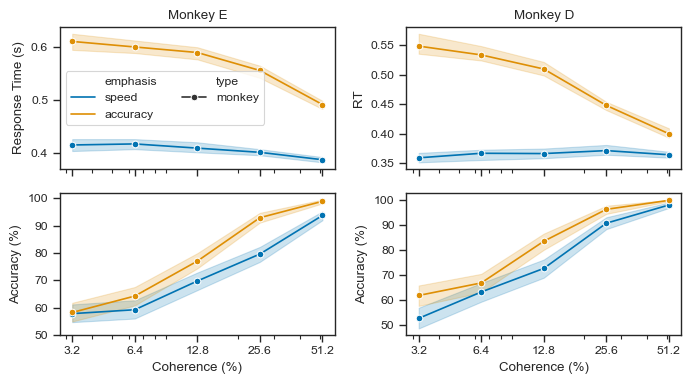

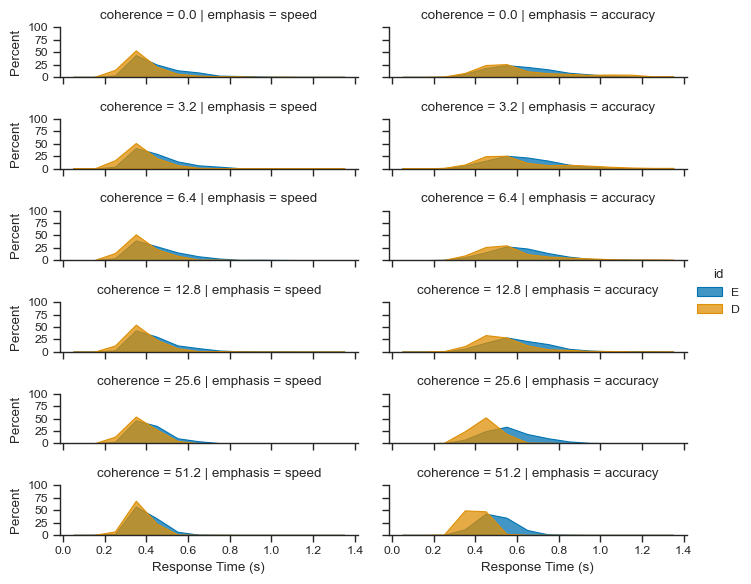

In [80]:
hanks_behavior = pd.read_pickle("data/hanks2014_behavior.pkl")
cohs = 100*np.array([0.032, 0.064, 0.128, 0.256, 0.512])
error = ('ci', 95)
estimator = np.median
bins = np.arange(0, 1.5, 0.1)

fig, axes = plt.subplots(nrows=2, ncols=2, sharex=True, figsize=((7.08, 4)))
for pid, name in enumerate(['E', 'D']):
    sns.lineplot(data=hanks_behavior.query("id==@name & coherence>0"), x='coherence', y='RT', hue='emphasis',
                 palette=palette[:2], markers=True, ax=axes[0][pid],
                 style='type', errorbar=error, estimator=estimator)
    sns.lineplot(data=hanks_behavior.query("id==@name & coherence>0"), x='coherence', y='accuracy', hue='emphasis',
                 style='type', palette=palette[:2], markers=True, ax=axes[1][pid])
    axes[0][pid].set(title=f"Monkey {name}")
axes[0][0].set(ylabel="Response Time (s)")
axes[0][0].legend(ncols=2)
axes[1][0].set(xscale='log', xticks=cohs, xticklabels=cohs, xlabel="Coherence (%)", ylabel="Accuracy (%)", yticks=[50,60,70,80,90,100])
axes[1][1].set(xscale='log', xticks=cohs, xticklabels=cohs, xlabel="Coherence (%)", ylabel="Accuracy (%)", yticks=[50,60,70,80,90,100])
axes[0][1].get_legend().remove()
axes[1][0].get_legend().remove()
axes[1][1].get_legend().remove()
plt.tight_layout()
fig.savefig(f"plots/hanks_SAT.svg")
fig.savefig(f"plots/hanks_SAT.png", dpi=600)

fig = sns.FacetGrid(hanks_behavior, col='emphasis', row="coherence", hue='id', palette=palette[:2], height=1, aspect=3.5, sharex=True, legend_out=True)
fig.map_dataframe(sns.histplot, x="RT", stat='percent', element="poly", common_norm=False, bins=bins)
fig.set_xlabels("Response Time (s)")
fig.set(xticks=bins[::2])
fig.set(yticks=[0,25,50,75,100])
fig.add_legend()
fig.savefig(f"plots/hanks_RTs.svg")
fig.savefig(f"plots/hanks_RTs.png", dpi=600)

## Empirical Firing Rates

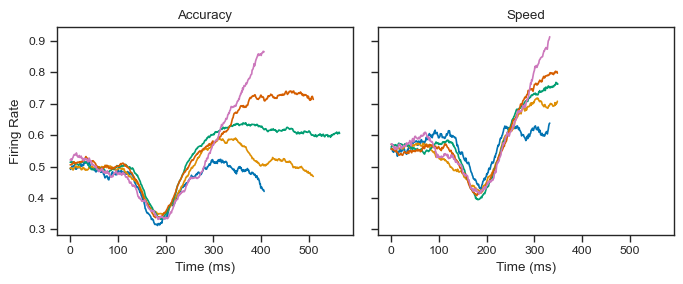

In [8]:
emp = scipy.io.loadmat("data/psthData.mat", simplify_cells=True)
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=((7, 3)), sharey=True, sharex=True)
sns.lineplot(emp['psth_forBo_acc'][0], color=palette[0], ax=axes[0])
sns.lineplot(emp['psth_forBo_acc'][1], color=palette[1], ax=axes[0])
sns.lineplot(emp['psth_forBo_acc'][2], color=palette[2], ax=axes[0])
sns.lineplot(emp['psth_forBo_acc'][3], color=palette[3], ax=axes[0])
sns.lineplot(emp['psth_forBo_acc'][4], color=palette[4], ax=axes[0])
sns.lineplot(emp['psth_forBo_sp'][0], color=palette[0], ax=axes[1])
sns.lineplot(emp['psth_forBo_sp'][1], color=palette[1], ax=axes[1])
sns.lineplot(emp['psth_forBo_sp'][2], color=palette[2], ax=axes[1])
sns.lineplot(emp['psth_forBo_sp'][3], color=palette[3], ax=axes[1])
sns.lineplot(emp['psth_forBo_sp'][4], color=palette[4], ax=axes[1])
axes[0].set(ylabel='Firing Rate', xlabel='Time (ms)', title='Accuracy')
axes[1].set(xlabel='Time (ms)', title='Speed')
plt.tight_layout()
fig.savefig(f"plots/hanks_psth.png", dpi=600)

In [4]:
def chi_squared_distance(a,b):
    distance = 0
    for i in range(len(a)):
        if a[i]+b[i]==0:
            continue
        else:
            distance += np.square(a[i] - b[i]) / (a[i]+b[i])
    return distance

def get_error(simulated, empirical, coherences, emphases, bins):
    for emphasis in emphases:
        chis = []
        accs = []
        for coherence in coherences:
            rts_sim = simulated.query("emphasis==@emphasis & coherence==@coherence")['RT'].to_numpy()
            rts_emp = empirical.query("emphasis==@emphasis & coherence==@coherence")['RT'].to_numpy()
            accs_sim = simulated.query("emphasis==@emphasis & coherence==@coherence")['accuracy'].to_numpy()
            accs_emp = empirical.query("emphasis==@emphasis & coherence==@coherence")['accuracy'].to_numpy()
            hist_rts_sim = np.histogram(rts_sim, bins=bins)[0]
            hist_rts_emp = np.histogram(rts_emp, bins=bins)[0]
            normed_hist_rts_sim = hist_rts_sim / len(rts_sim)
            normed_hist_rts_emp = hist_rts_emp / len(rts_emp)
            chi = chi_squared_distance(normed_hist_rts_sim, normed_hist_rts_emp)
            acc = np.abs(np.mean(accs_sim) - np.mean(accs_emp))
            chis.append(chi)
            accs.append(acc)
        print('emphasis', emphasis, f'chi2 {np.sum(chis):.3}', f'accuracy {np.sum(accs):.3}')

In [5]:
def rerun(
        coherences=np.array([0.032, 0.064, 0.128, 0.256, 0.512]),
        emphases=['speed', 'accuracy'],
        pid="E",
        ramp1=1.5,
        threshold1=0.3,
        relative1=0.5,
        ramp2=1,
        threshold2=0.3,
        relative2=0.5,
        sigma=0.5,
        nActions=2,
        nNeurons=500,
        max_rates=nengo.dists.Uniform(80, 100),
        rA=1.5,
        trials=3,
        perception_seed=0,
        network_seed=0,
        dt=0.001,
        dt_sample=0.03,
        load=False,
        error=('ci', 95),
        estimator=np.median,
        tmax=3,
        t0=0.1,
        t1=-0.1,
        bins=np.arange(0.0, 1.5, 0.1),
        name="hanks_activity_default"):
    
    columns = ('type', 'id', 'emphasis', 'coherence', 'trial', 'accuracy', "RT", 'mean buildup rate', 'mean final rate')
    dfs = []
    for e, emphasis in enumerate(emphases):
        ramp = [ramp1, ramp2][e]
        threshold = [threshold1, threshold2][e]
        relative = [relative1, relative2][e]
        inputs = DotPerception(nActions=nActions, dt_sample=dt_sample, seed=perception_seed, sigma=sigma)
        for coherence in coherences:
            inputs.create(coherence=coherence)
            for trial in range(trials):
                net = build_network(inputs, nActions=nActions, nNeurons=nNeurons, rA=rA, seed=trial,
                                    max_rates=max_rates, ramp=ramp, threshold=threshold, relative=relative,
                                    probe_spikes=True)
                sim = nengo.Simulator(net, progress_bar=False)
                choice = None
                while choice==None:
                    sim.run(dt)
                    if np.any(sim.data[net.pAction][-1,:] > 0.01):
                        choice = np.argmax(sim.data[net.pAction][-1,:])
                        RT = sim.trange()[-1]
                    if sim.trange()[-1] > tmax:
                        choice = np.argmax(sim.data[net.pValue][-1,:])
                        RT = sim.trange()[-1]
                correct = True if choice==inputs.correct else False
                aligned_neuron_idx = np.argwhere(sim.data[net.value].encoders[:,inputs.correct] > 0.9).ravel()
                print(f"emphasis {emphasis}, coherence {coherence}, trial {trial}, RT {RT}, aligned neurons {len(aligned_neuron_idx)}")
                DT = RT - t1
                buildup_rates = []
                final_rates = []
                for neuron in aligned_neuron_idx:
                    A0 = sim.data[net.pSpikes][int(t0/dt),neuron]
                    A1 = sim.data[net.pSpikes][int(t1/dt),neuron]
                    DA =  A1 - A0 
                    if A1!=0 and A0!=0:
                        buildup_rate = DA/DT
                        dfs.append(pd.DataFrame([['model', 'S', emphasis, 100*coherence, trial, 100*correct, RT, buildup_rate, A1]], columns=columns))
#                 dfs.append(pd.DataFrame([['model', 'S', emphasis, 100*coherence, trial, 100*correct, RT, np.mean(buildup_rates), np.mean(final_rates)]], columns=columns))
    data = pd.concat(dfs, ignore_index=True)
    data.to_pickle(f"data/{name}.pkl")

In [6]:
def plot_behavior(name, pid="E", estimator=np.mean, bins=np.arange(0.0, 1.5, 0.1)):
    data = pd.read_pickle(f"data/{name}.pkl")
    cohs = data['coherence'].unique()
    hanks = pd.read_pickle("data/hanks2014_behavior.pkl").query("id==@pid")
    combined = pd.concat([hanks, data]).query("coherence>0")
    get_error(data, hanks, cohs, ['speed', 'accuracy'], bins)

    fig, axes = plt.subplots(nrows=1, ncols=2, sharex=True, figsize=((7, 3)))
    sns.lineplot(data=combined.query("coherence>0"), x='coherence', y='RT', hue='emphasis',
                 palette=palette[:2], markers=True, ax=axes[0],
                 style='type', estimator=estimator)
    sns.lineplot(data=combined.query("coherence>0"), x='coherence', y='accuracy', hue='emphasis',
                 style='type', palette=palette[:2], markers=True, ax=axes[1])
    axes[0].set(xscale='log', xlabel="Coherence (%)", ylabel="Response Time (s)")
    axes[0].legend(ncols=2, loc='upper right')
    axes[1].set(xscale='log', xticks=cohs, xticklabels=cohs, xlabel="Coherence (%)", ylabel="Accuracy (%)", yticks=[50,60,70,80,90,100])
    axes[1].get_legend().remove()
    plt.tight_layout()
#     fig.savefig(f"plots/hanks_behavior.svg")
    fig.savefig(f"plots/hanks_behavior.png", dpi=600)
    
#     fig = sns.FacetGrid(combined, col='emphasis', row="coherence", hue='type', palette=palette[:2], height=1, aspect=3, sharex=True, legend_out=True)
#     fig.map_dataframe(sns.histplot, x="RT", stat='percent', element="poly", common_norm=False, bins=bins)
#     fig.set_xlabels("Response Time (s)")
#     fig.set(xticks=bins[::2])
#     fig.set(yticks=[0,25,50,75,100])
#     fig.add_legend()
#     fig.savefig(f"plots/hanks_RTs.svg")
#     fig.savefig(f"plots/hanks_RTs.png", dpi=600)

In [7]:
def plot_activity(name, estimator=np.mean, errorbar=('ci', 95)):
    data = pd.read_pickle(f"data/{name}.pkl")
    cohs = data['coherence'].unique()
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=((7, 3)))
    sns.lineplot(data=data, x='coherence', y='mean buildup rate', hue='emphasis',
                 palette=palette[:2], markers=True, ax=axes[0], style='type', errorbar=errorbar, estimator=estimator)
    sns.lineplot(data=data, x='coherence', y='mean final rate', hue='emphasis',
                 palette=palette[:2], markers=True, ax=axes[1], style='type', errorbar=errorbar, estimator=estimator)
    axes[0].set(xticks=cohs, xticklabels=cohs, xlabel="Coherence (%)", ylabel="Mean Buildup Rate (Hz/s)")
    axes[1].set(xticks=cohs, xticklabels=cohs, xlabel="Coherence (%)", ylabel="Mean Final Rate (Hz/s)")
    axes[0].legend(ncols=2, loc='upper right')
    axes[1].get_legend().remove()
    plt.tight_layout()
#     fig.savefig(f"plots/hanks_activity.svg")
    fig.savefig(f"plots/hanks_activity.png", dpi=600)

### Separate

In [ ]:
# rerun(trials=400, name='jan1abs', sigma=0.6, ramp1=1.61, relative1=0.0, threshold1=0.31, ramp2=1.81, relative2=0.0, threshold2=0.53)
# plot_behavior("jan1abs")
# plot_activity("jan1abs", errorbar=('pi', 20))

In [ ]:
# rerun(trials=400, name='jan1rel', sigma=0.6, ramp1=1.66, relative1=1.0, threshold1=0.12, ramp2=1.48, relative2=1.0, threshold2=0.13)
# plot_behavior("jan1rel")
# plot_activity("jan1rel", errorbar=('pi', 20))

emphasis speed chi2 0.446 accuracy 22.6
emphasis accuracy chi2 0.262 accuracy 5.89


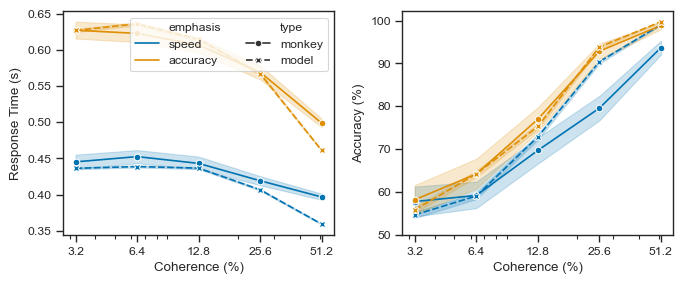

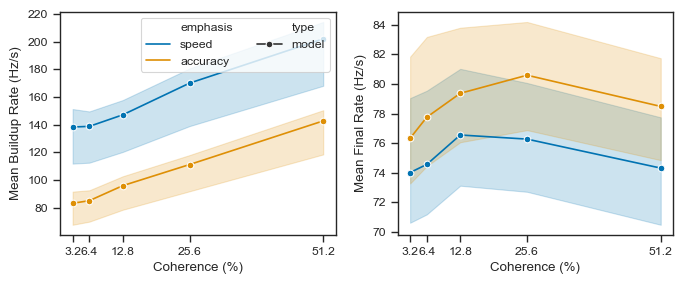

In [17]:
# rerun(trials=400, name='dec27sigma06', sigma=0.6, ramp1=1.79, relative1=0.02, threshold1=0.33, ramp2=1.81, relative2=0.24, threshold2=0.44)
plot_behavior("dec27sigma06")
plot_activity("dec27sigma06", errorbar=('pi', 20))

### Shared

In [ ]:
# rerun(trials=400, name='dec29shareTL', ramp1=1.82, relative1=0.28, threshold1=0.28, ramp2=1.19, relative2=0.28, threshold2=0.28, max_rates=nengo.dists.Uniform(80, 100))
# plot_behavior("dec29shareTL")
# plot_activity("dec29shareTL", errorbar=('pi', 20))

In [ ]:
# rerun(trials=400, name='dec29shareRL', max_rates=nengo.dists.Uniform(60, 80), ramp1=1.91, relative1=0.31, threshold1=0.3, ramp2=1.91, relative2=0.31, threshold2=0.45)
# plot_behavior("dec29shareRL")
# plot_activity("dec29shareRL", errorbar=('pi', 20))

In [ ]:
rerun(trials=400, name='dec29shareRT', ramp1=1.15, relative1=0.02, threshold1=0.22, ramp2=1.15, relative2=0.45, threshold2=0.22, max_rates=nengo.dists.Uniform(80, 100))
# plot_behavior("dec29shareRT")
# plot_activity("dec29shareRT", errorbar=('pi', 10))

In [20]:
def plot_shared(name, pid="E", estimator=np.mean, errorbar=('pi', 10), bins=np.arange(0.0, 1.5, 0.1)):
    data = pd.read_pickle(f"data/{name}.pkl")
    cohs = data['coherence'].unique()
    hanks = pd.read_pickle("data/hanks2014_behavior.pkl").query("id==@pid")
    combined = pd.concat([hanks, data]).query("coherence>0")

    fig, axes = plt.subplots(nrows=2, ncols=2, sharex=True, figsize=((7, 4)))
    sns.lineplot(data=combined.query("coherence>0"), x='coherence', y='RT', hue='emphasis',
                 palette=palette[:2], markers=True, ax=axes[0][0],
                 style='type', estimator=estimator)
    sns.lineplot(data=combined.query("coherence>0"), x='coherence', y='accuracy', hue='emphasis',
                 style='type', palette=palette[:2], markers=True, ax=axes[0][1])
    sns.lineplot(data=data, x='coherence', y='mean buildup rate', hue='emphasis',
                 palette=palette[:2], markers=True, ax=axes[1][0], style='type',
                 errorbar=errorbar, estimator=estimator)
    sns.lineplot(data=data, x='coherence', y='mean final rate', hue='emphasis',
                 palette=palette[:2], markers=True, ax=axes[1][1], style='type',
                 errorbar=errorbar, estimator=estimator)
        
    axes[0][0].set(ylabel=None, xscale='log', xlabel="Coherence (%)")
    axes[0][1].set(ylabel=None, xscale='log', xticks=cohs, xticklabels=cohs, xlabel="Coherence (%)", yticks=[50,60,70,80,90,100])
    axes[1][0].set(ylabel=None, xticks=cohs, xticklabels=cohs, xlabel="Coherence (%)")
    axes[1][1].set(ylabel=None, xticks=cohs, xticklabels=cohs, xlabel="Coherence (%)")
    axes[0][1].legend(loc='lower right', ncols=2)
    axes[1][1].get_legend().remove()
    axes[1][0].get_legend().remove()
    axes[0][0].get_legend().remove()
    # axes[3].get_legend().remove()
    axes[0][0].set(ylabel="Response\nTime (s)")
    axes[0][1].set(ylabel="Accuracy\n(%)")
    axes[1][0].set(ylabel="Buildup\nRate (Hz/s)")
    axes[1][1].set(ylabel="Final\nRate (Hz/s)")
    plt.tight_layout()
    fig.savefig(f"plots/hanks_shared.png", dpi=600)

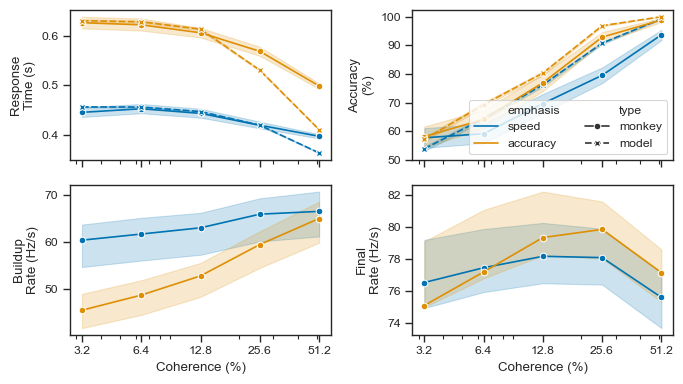

In [21]:
plot_shared("dec29shareRT")

In [15]:
def plot_shared_all(name1, name2, name3, pid="E", estimator=np.mean, errorbar=('pi', 20), bins=np.arange(0.0, 1.5, 0.1)):
    data1 = pd.read_pickle(f"data/{name1}.pkl")
    data2 = pd.read_pickle(f"data/{name2}.pkl")
    data3 = pd.read_pickle(f"data/{name3}.pkl")
    cohs = data1['coherence'].unique()
    hanks = pd.read_pickle("data/hanks2014_behavior.pkl").query("id==@pid")

    fig, axes = plt.subplots(nrows=4, ncols=3, sharex=True, figsize=((7, 6)))
    for i in range(3):
        data = [data1, data2, data3][i]
        combined = pd.concat([hanks, data]).query("coherence>0")
        sns.lineplot(data=combined.query("coherence>0"), x='coherence', y='RT', hue='emphasis',
                     palette=palette[:2], markers=True, ax=axes[0][i],
                     style='type', estimator=estimator)
        sns.lineplot(data=combined.query("coherence>0"), x='coherence', y='accuracy', hue='emphasis',
                     style='type', palette=palette[:2], markers=True, ax=axes[1][i])
        sns.lineplot(data=data, x='coherence', y='mean buildup rate', hue='emphasis',
                     palette=palette[:2], markers=True, ax=axes[2][i], style='type',
                     errorbar=errorbar, estimator=estimator)
        sns.lineplot(data=data, x='coherence', y='mean final rate', hue='emphasis',
                     palette=palette[:2], markers=True, ax=axes[3][i], style='type',
                     errorbar=errorbar, estimator=estimator)
        
#     axes[0][0].legend(ncols=1, loc='upper right')
#     axes[0][3].legend(ncols=1, loc='upper right')
    for i in range(3):
        axes[0][i].set(ylabel=None, xscale='log', xlabel="Coherence (%)")
        axes[1][i].set(ylabel=None, xscale='log', xticks=cohs, xticklabels=cohs, xlabel="Coherence (%)", yticks=[50,60,70,80,90,100])
        axes[2][i].set(ylabel=None, xticks=cohs, xticklabels=cohs, xlabel="Coherence (%)")
        axes[3][i].set(ylabel=None, xticks=cohs, xticklabels=cohs, xlabel="Coherence (%)")
#         if i>0:
        axes[0][i].get_legend().remove()
        axes[1][i].get_legend().remove()
        axes[2][i].get_legend().remove()
        axes[3][i].get_legend().remove()
#     axes[0][0].set(ylabel=f"{name1}")
#     axes[1][0].set(ylabel=f"{name2}")
#     axes[2][0].set(ylabel=f"{name3}")
    axes[0][0].set(title=r"$T$")
    axes[0][1].set(title=r"$L$")
    axes[0][2].set(title=r"$R$")
    axes[0][0].set(ylabel="Response\nTime (s)")
    axes[1][0].set(ylabel="Accuracy\n(%)")
    axes[2][0].set(ylabel="Buildup\nRate (Hz/s)")
    axes[3][0].set(ylabel="Final\nRate (Hz/s)")
    plt.tight_layout()
    fig.savefig(f"plots/hanks_shared.png", dpi=600)

In [ ]:
plot_shared_all("dec29shareRL", "dec29shareRT", "dec29shareTL")